In [1]:
import xml.etree.ElementTree as ET
import string
import os  
import re
import pandas as pd
import pickle 

In [2]:
import pandas as pd
url = 'https://github.com/petermr/CEVOpen/blob/master/classification/machine_learning_miniproject/labelled_sent_ack.csv'
train_data = pd.read_csv('C://Users//91981//CEVOpen//classification//machine_learning_miniproject//acknow_training_dataset.csv')


 


train_data = train_data.sample(frac=1).reset_index(drop=True)  #shufffle the dataset

In [3]:
train_data.head()

,sentences,label
0,"['The flowers, leaves and roots of E. ilicif...",not_acknow
1,We are grateful to Guy Erlich for providing th...,acknow
2,The ATR plate cleaning was verified by recordi...,not_acknow
3,About 80 g of beans were introduced in a grind...,not_acknow
4,['Blood was collected from the retro-orbital s...,not_acknow


In [4]:
train_data['category_id'] = train_data['label'].factorize()[0] # factorizing the output into zero and one

<AxesSubplot:xlabel='label'>

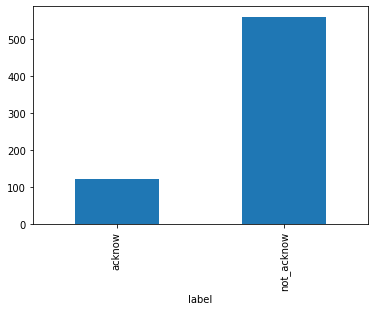

In [5]:
train_data.groupby('label').category_id.count().plot.bar(ylim=0)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer # term frequency & inverse document frequency (finding important words within text)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df= 5, norm ='max', encoding='latin-1', ngram_range=(1, 4), stop_words='english')
features = tfidf.fit_transform(train_data.sentences).toarray()
labels = train_data.category_id

In [7]:
category_to_id = {'acknow':0, 'not_acknow':1}
id_to_category = {0: 'acknow', 1: 'not_acknow'}

In [8]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2
import numpy as np

N = 10  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  print (f"{category_id} {Category}")
  features_chi2 = chi2(features, labels == category_id)  
  print(features_chi2)                 # Do chi2 analyses of all items in this category
  #index=0 # Possible error
  index=category_id
  indices = np.argsort(features_chi2[index]) 
  print(indices)                                 # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

0 acknow
(array([6.13257257e+00, 2.90634231e+00, 9.08726869e-01, 9.08726869e-01,
       3.75937500e+00, 1.44414048e+00, 9.19374934e-01, 2.22597286e-01,
       1.15973096e+00, 2.59653659e-01, 2.20410764e-01, 1.30551039e+00,
       1.12798903e+00, 1.12798903e+00, 9.95085201e-01, 2.85248712e+00,
       6.17623383e-01, 2.48717581e-01, 1.12218996e+00, 3.18586871e+00,
       4.19588587e-01, 6.76680470e-02, 1.07651246e+00, 8.56761053e-01,
       1.99155008e+00, 1.07651246e+00, 2.06000506e+00, 9.34359437e-01,
       9.31117851e-01, 1.35368737e+00, 8.95164832e-01, 2.03449853e+00,
       7.02260324e-01, 7.02260324e-01, 8.60914998e-01, 1.50074926e+00,
       1.66803987e+00, 1.91278965e+00, 8.47320218e-01, 9.79446922e-01,
       1.60045502e+00, 2.97724010e+00, 1.29151134e+00, 1.80842623e+00,
       9.39745857e-01, 1.06623804e+00, 1.06317385e+00, 1.37146124e+00,
       3.07754666e-01, 4.41060771e+01, 8.49924508e-01, 1.65179657e+00,
       2.55901066e+00, 1.01331563e+00, 1.62916773e+00, 1.62916773e+

In [9]:
##dimension reduction 
from sklearn.manifold import TSNE #low dimensionality plot

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 1)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

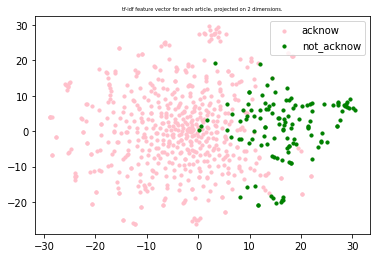

In [10]:
import matplotlib.pyplot as plt

colors = ['pink', 'green']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=10, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=5))
plt.legend()

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score


models = [
    
    RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3)
]

In [12]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

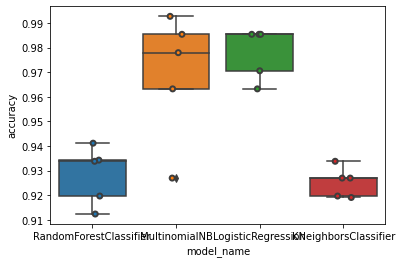

In [13]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.925333
LogisticRegression        0.978006
MultinomialNB             0.969257
RandomForestClassifier    0.928285
Name: accuracy, dtype: float64

In [15]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.919708
1,RandomForestClassifier,1,0.934307
2,RandomForestClassifier,2,0.912409
3,RandomForestClassifier,3,0.933824
4,RandomForestClassifier,4,0.941176
5,MultinomialNB,0,0.927007
6,MultinomialNB,1,0.992701
7,MultinomialNB,2,0.985401
8,MultinomialNB,3,0.977941
9,MultinomialNB,4,0.963235


In [16]:
from sklearn.model_selection import train_test_split


model = MultinomialNB()

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [17]:
category_id_df = train_data[['label', 'category_id']].drop_duplicates().sort_values('category_id')

Text(0.5, 14.09375, 'Predicted')

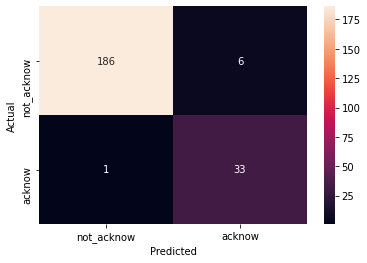

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
#run chi squared

In [19]:
from IPython.display import display

for predicted in category_id_df.category_id:
   for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(train_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['sentences'])
      print('')

'acknow' predicted as 'not_acknow' : 6 examples.


613    In this  in vitro study the plants were collec...
332    In order to investigate the heating effects on...
64           International Arctic Petroleum Cooperation.
17     A Cooperation of Toll-like receptor signals in...
413    IUCN Centre for Mediterranean Cooperation , Ca...
498    The fractional distillation was done in Labora...
Name: sentences, dtype: object

In [20]:
model2 = RandomForestClassifier()
model2.fit(features, labels)

RandomForestClassifier()

In [21]:
from IPython.display import display

for predicted in category_id_df.category_id:
   for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(train_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['sentences'])
      print('')

'acknow' predicted as 'not_acknow' : 6 examples.


613    In this  in vitro study the plants were collec...
332    In order to investigate the heating effects on...
64           International Arctic Petroleum Cooperation.
17     A Cooperation of Toll-like receptor signals in...
413    IUCN Centre for Mediterranean Cooperation , Ca...
498    The fractional distillation was done in Labora...
Name: sentences, dtype: object

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_data['sentences'], train_data['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [23]:
print(clf.predict(count_vect.transform(["S.L. and S.‐Q.Z. contributed equally to this work. This work was supported by the National Natural Science Foundation of China (51672156), Local Innovative Research Teams Project of Guangdong Pearl River Talents Program (No. 2017BT01N111), Guangdong Province Technical Plan Project (2017B010119001 and 2017B090907005), Shenzhen Technical Plan Project (JCYJ20180508152210821, JCYJ20170817161221958, and JCYJ20170412170706047), and major consulting and research projects of Tianjin Research Institute for Development Strategy of China's Engineering Science and Technology.","This research project was supported by a grant from the Research Centre of the Female Centre for Scientific and Medical Colleges of King Saud University","Collected plant material","The authors are grateful to FAPERJ, CNPq FOPESQ–UFF for financial support to the present work.","However, we acknowledge that this does not necessarily have to be the case for all time series, as individuals might die or not be detectable due to other reasons."])))

['acknow' 'acknow' 'not_acknow' 'acknow' 'not_acknow']


In [24]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))